# Context

in this notebook we are trying to optimise the best model form the selection phase to better target each different phylum. In that sense we are splitting the training and the modeling for the different phylumns  

# Imports

In [3]:
from google.colab import drive
import zipfile
drive.mount('/content/drive')

zip_path = '/content/drive/MyDrive/rare_species 1.zip'
extract_path = '/content/rare_species 1'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

Mounted at /content/drive


In [6]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow import data as tf_data
from tensorflow.keras import layers
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Rescaling, RandAugment

from sklearn.metrics import classification_report

In [8]:
# With colab
folder_path = '/content/rare_species 1'
meta = pd.read_csv('/content/rare_species 1/metadata.csv')

# With vscode
# folder_path = '../data/rare_species 1'
# meta = pd.read_csv('../data/rare_species 1/metadata.csv')

In [9]:
print(f"the diferent Phylum are: \n{meta['phylum'].unique()}")
print(f"each phylum contains :  \n{meta['phylum'].value_counts()}")

print(f"their is {meta['family'].nunique()} different families")

meta

the diferent Phylum are: 
['mollusca' 'chordata' 'arthropoda' 'echinodermata' 'cnidaria']
each phylum contains :  
phylum
chordata         9952
arthropoda        951
cnidaria          810
mollusca          210
echinodermata      60
Name: count, dtype: int64
their is 202 different families


,rare_species_id,eol_content_id,eol_page_id,kingdom,phylum,family,file_path
0,75fd91cb-2881-41cd-88e6-de451e8b60e2,12853737,449393,animalia,mollusca,unionidae,mollusca_unionidae/12853737_449393_eol-full-si...
1,28c508bc-63ff-4e60-9c8f-1934367e1528,20969394,793083,animalia,chordata,geoemydidae,chordata_geoemydidae/20969394_793083_eol-full-...
2,00372441-588c-4af8-9665-29bee20822c0,28895411,319982,animalia,chordata,cryptobranchidae,chordata_cryptobranchidae/28895411_319982_eol-...
3,29cc6040-6af2-49ee-86ec-ab7d89793828,29658536,45510188,animalia,chordata,turdidae,chordata_turdidae/29658536_45510188_eol-full-s...
4,94004bff-3a33-4758-8125-bf72e6e57eab,21252576,7250886,animalia,chordata,indriidae,chordata_indriidae/21252576_7250886_eol-full-s...
...,...,...,...,...,...,...,...
11978,1fa96ea5-32fa-4a25-b8d2-fa99f6e2cb89,29734618,1011315,animalia,chordata,leporidae,chordata_leporidae/29734618_1011315_eol-full-s...
11979,628bf2b4-6ecc-4017-a8e6-4306849e0cfc,29972861,1056842,animalia,chordata,emydidae,chordata_emydidae/29972861_1056842_eol-full-si...
11980,0ecfdec9-b1cd-4d43-96fc-2f8889ec1ad9,30134195,52572074,animalia,chordata,dasyatidae,chordata_dasyatidae/30134195_52572074_eol-full...
11981,27fdb1e9-c5fb-459a-8b6a-6fb222b1c512,9474963,46559139,animalia,chordata,mustelidae,chordata_mustelidae/9474963_46559139_eol-full-...


# Phylum Splits

This code splits the species into separate folders based on their phylum.  
This organization allows us to train a dedicated model for each phylum more effectively.<br>
(we repeat this proses in each notebook only because we are using colab)

In [10]:
# With colab
current_locations = '/content/rare_species 1'

# with vscode
# current_locations = '../data/rare_species 1'

for _, row in meta.iterrows():

    phylum = row['phylum']
    file_path = row['file_path']


    file_location = os.path.join(current_locations, file_path)

    # create a a detination folder keeping the subfolder structure

        # with colab
    target_folder = os.path.join(phylum, os.path.dirname(file_path))

        # with vscode
    # target_folder = os.path.join("../data" , phylum, os.path.dirname(file_path))

    os.makedirs(target_folder, exist_ok=True)  # Make sure the folder exists

    # Final destination path
    destination = os.path.join(target_folder, os.path.basename(file_path))

    # Copy the file if it exists
    if os.path.exists(file_location):
        shutil.copy2(file_location, destination)
    else:
        print(f"Couldn't find the file: {file_location}")

# Train Val Split

In [11]:
# with colab
path_phylum_chordata = "/content/arthropoda"


# with vscode
# path_phylum_chordata = "../data/chordata"


image_size = (224, 224)
seed = 42
batch_size = 32


train_ds_chordata, val_ds_chordata = keras.utils.image_dataset_from_directory(
    path_phylum_chordata,
    validation_split=0.2,
    subset="both",
    seed=seed,
    image_size= image_size,
    batch_size= batch_size
)


Found 951 files belonging to 17 classes.
Using 761 files for training.
Using 190 files for validation.


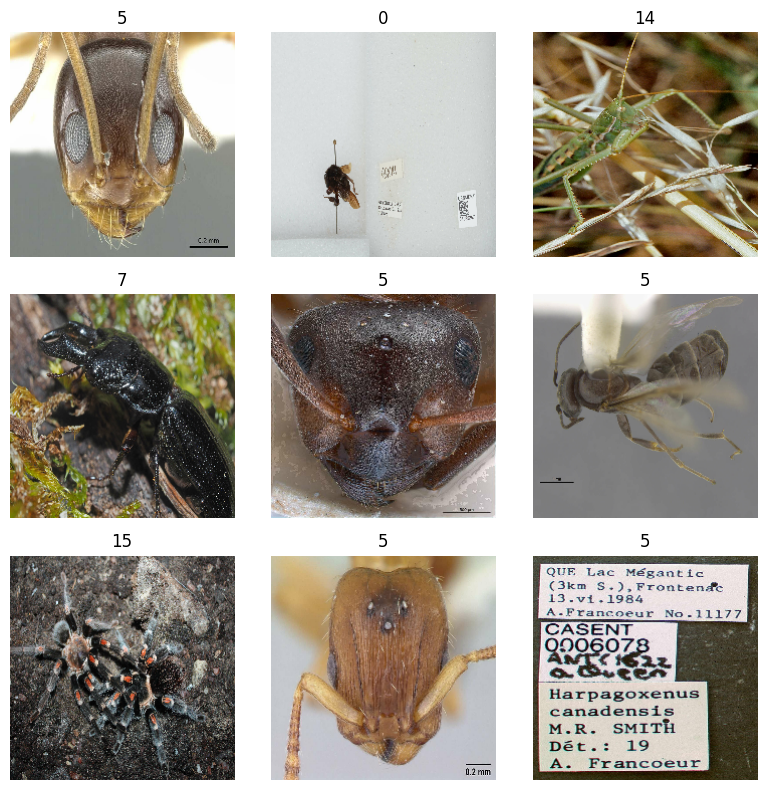

In [12]:
def display_images(train_ds):
    for images, labels in train_ds.take(1):
        plt.figure(figsize=(8, 8))
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(np.array(images[i]).astype("uint8"))
            plt.title(int(labels[i]))
            plt.axis("off")
        plt.tight_layout()
        plt.show()

display_images(train_ds_chordata)

# Augmentation layer

In [13]:
def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images

In [14]:
data_augmentation_layers = [
    RandAugment(value_range= (0, 255))
 ## add any you want here
]

# Model

In [ ]:
## to be adapted to the new dataset
def make_model_mobilenetv2(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Rescaling layer
    x = data_augmentation(inputs)
    x = Rescaling(1./255)(x)

    # Pretrained MobileNetV2 base
    base_model = MobileNetV2(include_top=False, input_tensor=x, weights="imagenet")
    base_model.trainable = False  # Freeze for transfer learning

    x = base_model.output
    x = layers.Flatten()(x)
    x = layers.Dropout(0.1)(x)  # Optional regularization

    outputs = layers.Dense(num_classes, activation="softmax")(x)

    return keras.Model(inputs, outputs)

In [ ]:
model_athoropa = make_model_mobilenetv2(input_shape=image_size + (3,), num_classes=17)
#keras.utils.plot_model(model_athoropa, show_shapes=False)

<ipython-input-13-cd2d24cef32f>:10: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(include_top=False, input_tensor=x, weights="imagenet")


# Run and evaluation

In [ ]:
epochs = 20

# make the learning rate change over the epochs to avoid getting stuck
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=3e-4,
    decay_steps=10000,
    decay_rate=0.9
)

callbacks = [
    # saves the best model of the run using max val_accuracy as a metric
    keras.callbacks.ModelCheckpoint(
        "best_model_chordata.keras",
        save_best_only=True,
        monitor="val_acc",
        mode="max",
        verbose=1)
    ]

## change from kera example is the loss function as we deal with a lot of classes
model_athoropa.compile(
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False), ## change this CategoricalCrossentropy to the the one it is now
    metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")], ## change this CategoricalCrossentropy to the the one it is now
)

model_athoropa.fit(
    train_ds_chordata,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds_chordata,
)

# get the clasification report
best_model_example = keras.models.load_model("best_model_chordata.keras")
y_pred_probs = best_model_example.predict(val_ds_chordata)
y_pred = np.argmax(y_pred_probs, axis=1)

y_true = np.concatenate([y for x, y in val_ds_chordata], axis=0)

print(classification_report(y_true, y_pred))

Epoch 1/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step - acc: 0.4578 - loss: 3.6765
Epoch 1: val_acc improved from -inf to 0.83158, saving model to best_model_chordata.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 25s 589ms/step - acc: 0.4636 - loss: 3.6256 - val_acc: 0.8316 - val_loss: 1.0301
Epoch 2/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - acc: 0.9736 - loss: 0.0556
Epoch 2: val_acc improved from 0.83158 to 0.86842, saving model to best_model_chordata.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 12s 483ms/step - acc: 0.9737 - loss: 0.0561 - val_acc: 0.8684 - val_loss: 0.7238
Epoch 3/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step - acc: 0.9963 - loss: 0.0456
Epoch 3: val_acc improved from 0.86842 to 0.87368, saving model to best_model_chordata.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 22s 540ms/step - acc: 0.9964 - loss: 0.0451 - val_acc: 0.8737 - val_loss: 0.6925
Epoch 4/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - acc: 1.0000 - loss: 3.4046e-04
Epoch 4: val_acc did not improve from 0.87368
24/24 ━━━━━━━━━━━━━━━━━━━━

Diffrent model


In [ ]:
def make_model_efficientnetv2l(input_shape, num_classes):
    from tensorflow.keras.applications import EfficientNetV2L

    inputs = keras.Input(shape=input_shape)

    # Rescaling layer
    x = data_augmentation(inputs)
    x = Rescaling(1./255)(x)

    # Pretrained EfficientNetV2L base
    base_model = EfficientNetV2L(include_top=False, input_tensor=x, weights="imagenet")
    base_model.trainable = False  # Freeze for transfer learning

    x = base_model.output
    x = layers.Flatten()(x)
    x = layers.Dropout(0.1)(x)  # Optional regularization

    outputs = layers.Dense(num_classes, activation="softmax")(x)

    return keras.Model(inputs, outputs)

In [ ]:
model_arthropoda = make_model_efficientnetv2l(input_shape=image_size + (3,), num_classes=17)
#keras.utils.plot_model(model_arthropoda, show_shapes=True)

473176280/473176280 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


In [ ]:
epochs = 20

# make the learning rate change over the epochs to avoid getting stuck
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=3e-4,
    decay_steps=10000,
    decay_rate=0.9
)

callbacks = [
    # saves the best model of the run using max val_accuracy as a metric
    keras.callbacks.ModelCheckpoint(
        "best_model_chordata1.keras",
        save_best_only=True,
        monitor="val_acc",
        mode="max",
        verbose=1)
    ]

## change from kera example is the loss function as we deal with a lot of classes
model_athoropa.compile(
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False), ## change this CategoricalCrossentropy to the the one it is now
    metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")], ## change this CategoricalCrossentropy to the the one it is now
)

model_athoropa.fit(
    train_ds_chordata,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds_chordata,
)

# get the clasification report
best_model_example = keras.models.load_model("best_model_chordata.keras")
y_pred_probs = best_model_example.predict(val_ds_chordata)
y_pred = np.argmax(y_pred_probs, axis=1)

y_true = np.concatenate([y for x, y in val_ds_chordata], axis=0)

print(classification_report(y_true, y_pred))

Epoch 1/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - acc: 0.8457 - loss: 0.7153
Epoch 1: val_acc improved from -inf to 0.84737, saving model to best_model_chordata1.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 20s 568ms/step - acc: 0.8451 - loss: 0.7214 - val_acc: 0.8474 - val_loss: 1.0191
Epoch 2/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step - acc: 0.8873 - loss: 0.5584
Epoch 2: val_acc improved from 0.84737 to 0.87368, saving model to best_model_chordata1.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 18s 492ms/step - acc: 0.8874 - loss: 0.5596 - val_acc: 0.8737 - val_loss: 0.8979
Epoch 3/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step - acc: 0.9410 - loss: 0.3633
Epoch 3: val_acc did not improve from 0.87368
24/24 ━━━━━━━━━━━━━━━━━━━━ 20s 476ms/step - acc: 0.9402 - loss: 0.3652 - val_acc: 0.8684 - val_loss: 0.8080
Epoch 4/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step - acc: 0.9443 - loss: 0.2150
Epoch 4: val_acc did not improve from 0.87368
24/24 ━━━━━━━━━━━━━━━━━━━━ 20s 451ms/step - acc: 0.9438 - loss: 0.2183 - va

anderes Model


In [15]:
def make_model_resnet152v2(input_shape, num_classes):
    from tensorflow.keras.applications import ResNet152V2

    inputs = keras.Input(shape=input_shape)

    # Rescaling layer
    x = data_augmentation(inputs)
    x = Rescaling(1./255)(x)

    # Pretrained ResNet152V2 base
    base_model = ResNet152V2(include_top=False, input_tensor=x, weights="imagenet")
    base_model.trainable = False  # Freeze for transfer learning

    x = base_model.output
    x = layers.Flatten()(x)
    x = layers.Dropout(0.1)(x)  # Optional regularization

    outputs = layers.Dense(num_classes, activation="softmax")(x)

    return keras.Model(inputs, outputs)



In [16]:
model_arthropoda = make_model_resnet152v2(input_shape=image_size + (3,), num_classes=17)
#keras.utils.plot_model(model_arthropoda, show_shapes=True)

234545216/234545216 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
epochs = 20

# make the learning rate change over the epochs to avoid getting stuck
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=3e-4,
    decay_steps=10000,
    decay_rate=0.9
)

callbacks = [
    # saves the best model of the run using max val_accuracy as a metric
    keras.callbacks.ModelCheckpoint(
        "best_model_chordata1.keras",
        save_best_only=True,
        monitor="val_acc",
        mode="max",
        verbose=1)
    ]

## change from kera example is the loss function as we deal with a lot of classes
model_athoropa.compile(
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False), ## change this CategoricalCrossentropy to the the one it is now
    metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")], ## change this CategoricalCrossentropy to the the one it is now
)

model_athoropa.fit(
    train_ds_chordata,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds_chordata,
)

# get the clasification report
best_model_example = keras.models.load_model("best_model_chordata.keras")
y_pred_probs = best_model_example.predict(val_ds_chordata)
y_pred = np.argmax(y_pred_probs, axis=1)

y_true = np.concatenate([y for x, y in val_ds_chordata], axis=0)

print(classification_report(y_true, y_pred))

Epoch 1/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step - acc: 0.8485 - loss: 1.1209
Epoch 1: val_acc improved from -inf to 0.86842, saving model to best_model_chordata1.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 24s 564ms/step - acc: 0.8483 - loss: 1.1216 - val_acc: 0.8684 - val_loss: 1.4615
Epoch 2/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step - acc: 0.8841 - loss: 1.0560
Epoch 2: val_acc did not improve from 0.86842
24/24 ━━━━━━━━━━━━━━━━━━━━ 14s 485ms/step - acc: 0.8843 - loss: 1.0486 - val_acc: 0.8474 - val_loss: 1.4828
Epoch 3/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step - acc: 0.9005 - loss: 0.7175
Epoch 3: val_acc did not improve from 0.86842
24/24 ━━━━━━━━━━━━━━━━━━━━ 20s 442ms/step - acc: 0.9004 - loss: 0.7188 - val_acc: 0.8368 - val_loss: 1.8413
Epoch 4/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step - acc: 0.9131 - loss: 0.4695
Epoch 4: val_acc did not improve from 0.86842
24/24 ━━━━━━━━━━━━━━━━━━━━ 22s 518ms/step - acc: 0.9136 - loss: 0.4678 - val_acc: 0.8211 - val_loss: 1.7418
Epoch 5/20
24/2

6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 346ms/step
              precision    recall  f1-score   support

           0       0.94      0.97      0.95        32
           1       0.75      0.50      0.60         6
           2       0.78      0.64      0.70        11
           3       0.83      0.71      0.77         7
           4       0.83      1.00      0.91         5
           5       0.90      1.00      0.95        61
           6       0.64      1.00      0.78         7
           7       1.00      0.50      0.67         4
           8       1.00      0.89      0.94         9
           9       1.00      1.00      1.00         8
          10       1.00      1.00      1.00         7
          11       1.00      0.57      0.73         7
          12       1.00      0.86      0.92         7
          13       0.83      0.56      0.67         9
          14       0.67      0.67      0.67         3
          15       1.00      1.00      1.00         2
          16       0.71      1.00      0.8

anderes Model

In [ ]:
def make_model_densenet201(input_shape, num_classes):
    from tensorflow.keras.applications import DenseNet201

    inputs = keras.Input(shape=input_shape)

    # Rescaling layer
    x = data_augmentation(inputs)
    x = Rescaling(1./255)(x)

    # Pretrained DenseNet201 base
    base_model = DenseNet201(include_top=False, input_tensor=x, weights="imagenet")
    base_model.trainable = False  # Freeze for transfer learning

    x = base_model.output
    x = layers.Flatten()(x)
    x = layers.Dropout(0.1)(x)  # Optional regularization

    outputs = layers.Dense(num_classes, activation="softmax")(x)

    return keras.Model(inputs, outputs)

In [17]:
model_arthropoda = make_model_resnet152v2(input_shape=image_size + (3,), num_classes=17)
#keras.utils.plot_model(model_arthropoda, show_shapes=True)

In [ ]:
epochs = 20

# make the learning rate change over the epochs to avoid getting stuck
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=3e-4,
    decay_steps=10000,
    decay_rate=0.9
)

callbacks = [
    # saves the best model of the run using max val_accuracy as a metric
    keras.callbacks.ModelCheckpoint(
        "best_model_chordata1.keras",
        save_best_only=True,
        monitor="val_acc",
        mode="max",
        verbose=1)
    ]

## change from kera example is the loss function as we deal with a lot of classes
model_athoropa.compile(
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False), ## change this CategoricalCrossentropy to the the one it is now
    metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")], ## change this CategoricalCrossentropy to the the one it is now
)

model_athoropa.fit(
    train_ds_chordata,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds_chordata,
)

# get the clasification report
best_model_example = keras.models.load_model("best_model_chordata.keras")
y_pred_probs = best_model_example.predict(val_ds_chordata)
y_pred = np.argmax(y_pred_probs, axis=1)

y_true = np.concatenate([y for x, y in val_ds_chordata], axis=0)

print(classification_report(y_true, y_pred))

Epoch 1/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step - acc: 0.8857 - loss: 0.8316
Epoch 1: val_acc improved from -inf to 0.86316, saving model to best_model_chordata1.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 18s 562ms/step - acc: 0.8859 - loss: 0.8325 - val_acc: 0.8632 - val_loss: 1.7890
Epoch 2/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - acc: 0.9246 - loss: 0.7621
Epoch 2: val_acc did not improve from 0.86316
24/24 ━━━━━━━━━━━━━━━━━━━━ 17s 429ms/step - acc: 0.9245 - loss: 0.7583 - val_acc: 0.8632 - val_loss: 1.8882
Epoch 3/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step - acc: 0.9358 - loss: 0.5093
Epoch 3: val_acc did not improve from 0.86316
24/24 ━━━━━━━━━━━━━━━━━━━━ 12s 482ms/step - acc: 0.9356 - loss: 0.5081 - val_acc: 0.8211 - val_loss: 2.3942
Epoch 4/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step - acc: 0.9513 - loss: 0.3185
Epoch 4: val_acc did not improve from 0.86316
24/24 ━━━━━━━━━━━━━━━━━━━━ 12s 508ms/step - acc: 0.9514 - loss: 0.3158 - val_acc: 0.8526 - val_loss: 2.1881
Epoch 5/20
24/2

6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 529ms/step
              precision    recall  f1-score   support

           0       0.94      0.97      0.95        32
           1       0.75      0.50      0.60         6
           2       0.78      0.64      0.70        11
           3       0.83      0.71      0.77         7
           4       0.83      1.00      0.91         5
           5       0.90      1.00      0.95        61
           6       0.64      1.00      0.78         7
           7       1.00      0.50      0.67         4
           8       1.00      0.89      0.94         9
           9       1.00      1.00      1.00         8
          10       1.00      1.00      1.00         7
          11       1.00      0.57      0.73         7
          12       1.00      0.86      0.92         7
          13       0.83      0.56      0.67         9
          14       0.67      0.67      0.67         3
          15       1.00      1.00      1.00         2
          16       0.71      1.00      0.8

anderes model

In [20]:

# NASNetLarge Model (requires 331x331 input size)
def make_model_nasnetlarge(input_shape, num_classes):
    from tensorflow.keras.applications import NASNetLarge


    inputs = keras.Input(shape=input_shape)

    # Rescaling layer
    x = data_augmentation(inputs)
    x = Rescaling(1./255)(x)

    # Pretrained NASNetLarge base
    base_model = NASNetLarge(include_top=False, input_tensor=x, weights="imagenet")
    base_model.trainable = False  # Freeze for transfer learning

    x = base_model.output
    x = layers.Flatten()(x)
    x = layers.Dropout(0.1)(x)  # Optional regularization

    outputs = layers.Dense(num_classes, activation="softmax")(x)

    return keras.Model(inputs, outputs)

In [ ]:
nasnet_image_size = (331, 331)
model_arthropoda = make_model_nasnetlarge(input_shape=nasnet_image_size + (3,), num_classes=17)
#keras.utils.plot_model(model_arthropoda, show_shapes=True)

In [ ]:
epochs = 20

# make the learning rate change over the epochs to avoid getting stuck
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=3e-4,
    decay_steps=10000,
    decay_rate=0.9
)

callbacks = [
    # saves the best model of the run using max val_accuracy as a metric
    keras.callbacks.ModelCheckpoint(
        "best_model_chordata1.keras",
        save_best_only=True,
        monitor="val_acc",
        mode="max",
        verbose=1)
    ]

## change from kera example is the loss function as we deal with a lot of classes
model_athoropa.compile(
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False), ## change this CategoricalCrossentropy to the the one it is now
    metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")], ## change this CategoricalCrossentropy to the the one it is now
)

model_athoropa.fit(
    train_ds_chordata,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds_chordata,
)

# get the clasification report
best_model_example = keras.models.load_model("best_model_chordata.keras")
y_pred_probs = best_model_example.predict(val_ds_chordata)
y_pred = np.argmax(y_pred_probs, axis=1)

y_true = np.concatenate([y for x, y in val_ds_chordata], axis=0)

print(classification_report(y_true, y_pred))

Epoch 1/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step - acc: 0.6393 - loss: 4.6529
Epoch 1: val_acc improved from -inf to 0.83684, saving model to best_model_chordata1.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 20s 555ms/step - acc: 0.6398 - loss: 4.6364 - val_acc: 0.8368 - val_loss: 2.8000
Epoch 2/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step - acc: 0.7319 - loss: 3.0270
Epoch 2: val_acc improved from 0.83684 to 0.86842, saving model to best_model_chordata1.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 20s 536ms/step - acc: 0.7316 - loss: 3.0338 - val_acc: 0.8684 - val_loss: 1.9107
Epoch 3/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - acc: 0.8087 - loss: 1.9351
Epoch 3: val_acc did not improve from 0.86842
24/24 ━━━━━━━━━━━━━━━━━━━━ 19s 480ms/step - acc: 0.8085 - loss: 1.9338 - val_acc: 0.8579 - val_loss: 1.9380
Epoch 4/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step - acc: 0.8166 - loss: 1.7171
Epoch 4: val_acc improved from 0.86842 to 0.87368, saving model to best_model_chordata1.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 